# Baseline LSTM model

## Notebook set-up

In [1]:
# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

# Internal imports
import perdrizet_helper_funcs

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

2025-01-26 20:33:30.486511: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 20:33:30.747034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 20:33:30.943300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737923611.246620   10622 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737923611.340880   10622 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 20:33:31.946382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)

# Drop the synthetic features to set a baseline with just incident count
synthetic_features=['diff_detrended_incidents','linear_detrended_incidents','raw_clipped_incidents','diff_clipped_incidents','linear_clipped_incidents','raw_clipped_transformed_incidents','diff_clipped_transformed_incidents','linear_clipped_transformed_incidents']
data_df.drop(synthetic_features, axis=1, inplace=True)

# Save the index of the target column
target_column_index=data_df.columns.get_loc('incidents_binary')

# Get and show some summary statistics
total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 1986(4.7%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41899 entries, (np.int64(1955), 'AK', np.int64(1)) to (np.int64(2019), 'WY', np.int64(12))
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incidents         41899 non-null  int64  
 1   month_sin         41899 non-null  float64
 2   month_cos         41899 non-null  float64
 3   AL                41899 non-null  int64  
 4   AR                41899 non-null  int64  
 5   AS                41899 non-null  int64  
 6   AZ                41899 non-null  int64  
 7   CA                41899 non-null  int64  
 8   CO                41899 non-null  int64  
 9   CT                41899 non-null  int64  
 10  DC                41899 non-null  int64  
 11  DE                41899 non-null  int64  
 12  FL                41899 non-null  int64  
 13  FM                41899 non-null  int64  
 14  GA                41899 non-null  in

In [3]:
data_df.describe()

,incidents,month_sin,month_cos,AL,AR,AS,AZ,CA,CO,CT,...,TX,UT,VA,VI,VT,WA,WI,WV,WY,incidents_binary
count,41899.000000,4.189900e+04,4.189900e+04,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,...,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000
mean,0.915201,-1.793384e-03,-1.557622e-04,0.016874,0.017948,0.015442,0.015394,0.018616,0.018521,0.018616,...,0.018616,0.012315,0.018020,0.015919,0.016086,0.018306,0.015681,0.018616,0.016182,0.047400
std,7.531568,7.069399e-01,7.072882e-01,0.128801,0.132764,0.123304,0.123116,0.135167,0.134826,0.135167,...,0.135167,0.110290,0.133023,0.125165,0.125809,0.134057,0.124238,0.135167,0.126176,0.212495
min,0.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,5.000000e-01,8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,509.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


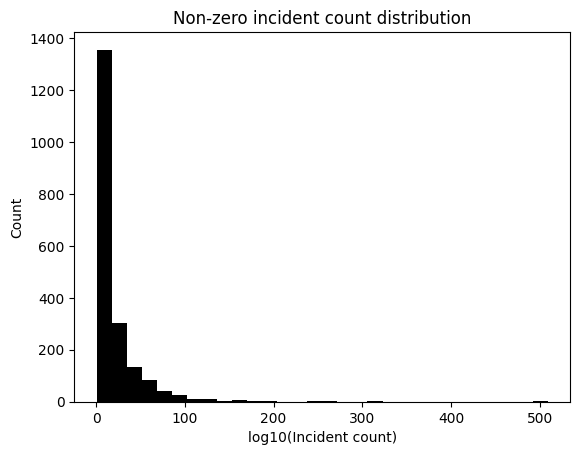

In [4]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

In [5]:
data_df.head()

incidents  month_sin     month_cos  AL  AR  AS  AZ  CA  CO  \
year state month                                                               
1955 AK    1              0   0.500000  8.660254e-01   0   0   0   0   0   0   
           2              0   0.866025  5.000000e-01   0   0   0   0   0   0   
           3              0   1.000000  6.123234e-17   0   0   0   0   0   0   
           4              0   0.866025 -5.000000e-01   0   0   0   0   0   0   
           5              0   0.500000 -8.660254e-01   0   0   0   0   0   0   

                  CT  ...  TX  UT  VA  VI  VT  WA  WI  WV  WY  \
year state month      ...                                       
1955 AK    1       0  ...   0   0   0   0   0   0   0   0   0   
           2       0  ...   0   0   0   0   0   0   0   0   0   
           3       0  ...   0   0   0   0   0   0   0   0   0   
           4       0  ...   0   0   0   0   0   0   0   0   0   
           5       0  ...   0   0   0   0   0   0   0   0   0   

                  incidents_binary  
year state month                    
1955 AK    1                     0  
           2                     0  
           3                     0  
           4                     0  
           5                     0  

[5 rows x 62 columns]

## 2. Train-test split

Take the most recent ~10% of the data for testing.

In [6]:
# Get list of years
years=data_df.index.get_level_values('year').unique().tolist()
testing_years=len(years) // 10
print(f'Using most recent {testing_years} of {len(years)} years for test set')
print(f'Testing years: {years[-testing_years:]}')
print(f'Training years: {years[:-testing_years]}')

# Take last 5 years for testing data
testing_df=data_df.loc[years[-testing_years:]]

# Take the rest for training
training_df=data_df.loc[years[:-testing_years]]

# Check result
training_df.head()

Using most recent 6 of 65 years for test set
Testing years: [2014, 2015, 2016, 2017, 2018, 2019]
Training years: [1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


incidents  month_sin     month_cos  AL  AR  AS  AZ  CA  CO  \
year state month                                                               
1955 AK    1              0   0.500000  8.660254e-01   0   0   0   0   0   0   
           2              0   0.866025  5.000000e-01   0   0   0   0   0   0   
           3              0   1.000000  6.123234e-17   0   0   0   0   0   0   
           4              0   0.866025 -5.000000e-01   0   0   0   0   0   0   
           5              0   0.500000 -8.660254e-01   0   0   0   0   0   0   

                  CT  ...  TX  UT  VA  VI  VT  WA  WI  WV  WY  \
year state month      ...                                       
1955 AK    1       0  ...   0   0   0   0   0   0   0   0   0   
           2       0  ...   0   0   0   0   0   0   0   0   0   
           3       0  ...   0   0   0   0   0   0   0   0   0   
           4       0  ...   0   0   0   0   0   0   0   0   0   
           5       0  ...   0   0   0   0   0   0   0   0   0   

                  incidents_binary  
year state month                    
1955 AK    1                     0  
           2                     0  
           3                     0  
           4                     0  
           5                     0  

[5 rows x 62 columns]

## 3. Feature scaling

In [7]:
# Scale each column to (0,1) - first fit the MinMax scaler on the training df
scaler=MinMaxScaler()
scaler.fit(np.array(training_df))

# Then scale the training and testing data
scaled_training_data=scaler.transform(np.array(training_df))
scaled_testing_data=scaler.transform(np.array(testing_df))

# Rebuild the dataframes
scaled_training_df=pd.DataFrame(scaled_training_data, columns=training_df.columns.astype(str))
scaled_training_df.set_index(training_df.index, inplace=True)

scaled_testing_df=pd.DataFrame(scaled_testing_data, columns=testing_df.columns.astype(str))
scaled_testing_df.set_index(testing_df.index, inplace=True)

# Check the result
scaled_training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
incidents,37867.0,0.001664,0.013869,0.0,0.000000,0.0,0.000000,1.0
month_sin,37867.0,0.499008,0.353461,0.0,0.066987,0.5,0.750000,1.0
month_cos,37867.0,0.499914,0.353654,0.0,0.066987,0.5,0.933013,1.0
AL,37867.0,0.016769,0.128407,0.0,0.000000,0.0,0.000000,1.0
AR,37867.0,0.017958,0.132799,0.0,0.000000,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...
WA,37867.0,0.018354,0.134229,0.0,0.000000,0.0,0.000000,1.0
WI,37867.0,0.015449,0.123331,0.0,0.000000,0.0,0.000000,1.0
WV,37867.0,0.018697,0.135455,0.0,0.000000,0.0,0.000000,1.0
WY,37867.0,0.016003,0.125490,0.0,0.000000,0.0,0.000000,1.0


## 3. Data formatting & training-validation splitting

In [8]:
# Run custom splitting function
training_features, training_labels, validation_features, validation_labels, states=perdrizet_helper_funcs.make_time_course(scaled_training_df)

# Check the result
print(f'State batches: {len(training_features)}')

for state, features, labels in zip(states, training_features, training_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

State batches: 58
AK: features: (494, 1, 62), labels: (494, 1)
CA: features: (494, 1, 62), labels: (494, 1)
CO: features: (491, 1, 62), labels: (491, 1)
CT: features: (494, 1, 62), labels: (494, 1)
FL: features: (494, 1, 62), labels: (494, 1)
GA: features: (494, 1, 62), labels: (494, 1)
HI: features: (492, 1, 62), labels: (492, 1)
IA: features: (494, 1, 62), labels: (494, 1)
IN: features: (494, 1, 62), labels: (494, 1)
KS: features: (491, 1, 62), labels: (491, 1)
LA: features: (494, 1, 62), labels: (494, 1)
MA: features: (494, 1, 62), labels: (494, 1)
ME: features: (494, 1, 62), labels: (494, 1)
MI: features: (494, 1, 62), labels: (494, 1)
MS: features: (494, 1, 62), labels: (494, 1)
MT: features: (494, 1, 62), labels: (494, 1)
NC: features: (494, 1, 62), labels: (494, 1)
NH: features: (494, 1, 62), labels: (494, 1)
NJ: features: (489, 1, 62), labels: (489, 1)
NM: features: (494, 1, 62), labels: (494, 1)
NV: features: (494, 1, 62), labels: (494, 1)
NY: features: (494, 1, 62), labels: (

## 4. Initial model training

In [ ]:
%%time

# Training details
training_iterations=50
training_epochs=5
learning_rate=0.00001

# Build the model
model=perdrizet_helper_funcs.build_lstm(
    training_features[0].shape[1],
    training_features[0].shape[2],
    learning_rate=learning_rate
)

# Print out the model structure
model.summary()

# Get the class weights
class_weight=perdrizet_helper_funcs.get_class_weights(scaled_training_df)

# Manually train the model iteratively over the state time courses using each for a single batch training run
true_epoch=0
training_results=[]
metrics=['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall']

for iteration in range(training_iterations):

    # Make an empty dict to store metric results for this iteration
    metric_data={}

    for metric in metrics:
        metric_data[metric]=[]

    # Loop over the state time courses
    for i in range(len(training_features)):

        # Count total training epochs
        true_epoch+=1

        # Train on this state
        batch_result, model=perdrizet_helper_funcs.train_lstm(
            model,
            training_features[i],
            training_labels[i],
            validation_features[i],
            validation_labels[i],
            class_weight,
            epochs=training_epochs,
            batch_size=training_features[i].shape[0]
        )

        # Collect the state-level training result
        training_results.append(batch_result)

        # Collect metrics for state-level training run
        for metric in metrics:
            metric_data[metric].extend(batch_result.history[metric])

    # Print metic means across states for every 5th iteration
    if iteration % 10 == 0:
        print(f'Training iteration {iteration} mean: ', end='')

        for metric in metrics:
            print(f'{metric}={sum(metric_data[metric])/len(metric_data[metric]):.3f} ', end='')
        
        print()

# Draw the training curves
perdrizet_helper_funcs.plot_single_training_run(
    training_results,
    len(states),
    training_epochs
).show()

2025-01-26 20:33:39.171138: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-01-26 20:33:39.227724: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-01-26 20:33:39.276025: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-01-26 20:33:39.300680: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-01-26 20:33:39.333035: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-01-26 20:33:40.128339: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM.1 (LSTM)                   │ (None, 1, 1024)        │     4,452,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM.2 (LSTM)                   │ (None, 1, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM.3 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense.1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense.2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense.3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,490,433 (32.39 MB)

 Trainable params: 8,490,433 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

Training iteration 0 mean: loss=0.584 precision=0.001 recall=0.000 val_loss=0.683 val_precision=0.000 val_recall=0.000 


## 5. Model evaluation

### 5.1. Make predictions on test set

In [20]:
# Format test data for predictions
testing_features=[]
testing_labels=[]

for i in range(len(scaled_testing_df) - 1):

    testing_features.append([scaled_testing_df.iloc[i]])
    testing_labels.append([scaled_testing_df.iloc[i + 1]['incidents_binary']])

# Check the result
print(f'Testing features shape: {np.array(testing_features).shape}')
print(f'Testing labels shape: {np.array(testing_labels).shape}')

Testing features shape: (4031, 1, 62)
Testing labels shape: (4031, 1)


In [21]:
# Make the predictions
predictions=[]

for features in testing_features:
    predictions.extend(model.predict(np.array([features]), verbose=0))

predictions_df=pd.DataFrame.from_dict({'labels': np.array(testing_labels).flatten(), 'probabilities': np.array(predictions).flatten()})
predictions_df.head()

,labels,probabilities
0,0.0,0.227648
1,0.0,0.245398
2,0.0,0.266001
3,0.0,0.285159
4,0.0,0.297596


### 5.2. Distribution of predicted incident probabilities

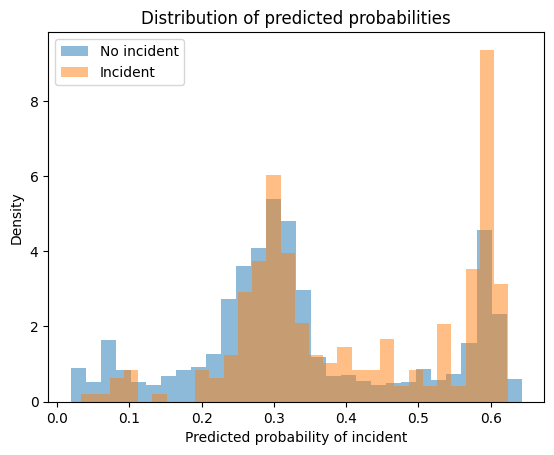

In [22]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### 5.3. Receiver-operator characteristic and precision-recall curves

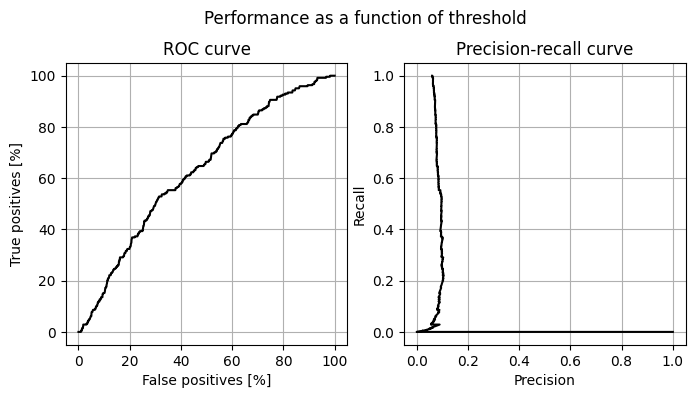

In [23]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('Performance as a function of threshold', size='large')

# Plot ROC curve
fp, tp, _ = roc_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _ = precision_recall_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

### 5.4. Confusion matrix

Precision: 0.095
Recall: 0.373



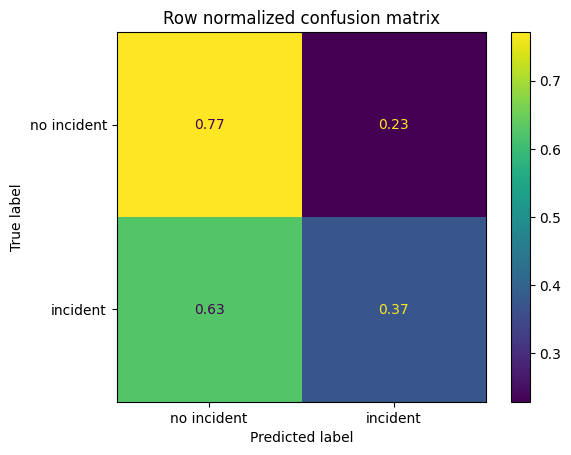

In [24]:
# Set threshold and call incidents
threshold=0.5
calls=np.where(predictions_df['probabilities'] > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(predictions_df['labels'], calls)
recall=recall_score(testing_labels, calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['labels'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('Row normalized confusion matrix')
plt.show()